# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
 
### Purpose

We will now reduce the number of outputs of the private quadratic model to this how the accuracy on the main and on the collateral learning tasks evolves. To do this, we will add a CNN on top of the private NN also for the main task (here character recognition).

In [1]:
FORCE_RETRAIN = False  # Should you retrain models that you already trained and stored.
# Set it to True if you change of model.

# 1. Main task


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import main, train, test, show_results, get_test_loader

In [4]:
OUT_SIZE_RANGE = [2, 4, 8, 16, 26] # range of size of output for the private quadratic part
PREC_FRAC = 3 # precision fractional parameter for the fixed precision

class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

Let's define the quadratic model with its CNN part.

In [5]:
class QuadConvNet(nn.Module):
    def __init__(self, private_output_size, output_size):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, private_output_size)
        
        # --- Junction
        self.jct = nn.Linear(private_output_size, 784)
        
        # --- CNN
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        # -- Private Quad
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def fixp_forward(self, x, precision_fractional):
        """Like forward but with the private part converted in fixed precision"""
        # -- Private Quad
        self.private_fix_precision_(precision_fractional)  # <-- New
        x.fix_precision_(precision_fractional)  # <-- New
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        x.float_precision_()  # <-- New
        self.private_float_precision_()  # <-- New
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def private_fix_precision_(self, precision_fractional):
        """Perform fix_precision_() just on the private / quad parameters"""
        self.proj1.bias.fix_precision_(precision_fractional=precision_fractional)
        self.proj1.weight.fix_precision_(precision_fractional=precision_fractional)
        self.diag1.bias.fix_precision_(precision_fractional=precision_fractional)
        self.diag1.weight.fix_precision_(precision_fractional=precision_fractional)
        
    def private_float_precision_(self):
        """Perform float_precision_() just on the private / quad parameters"""
        self.proj1.bias.float_precision_()
        self.proj1.weight.float_precision_()
        self.diag1.bias.float_precision_()
        self.diag1.weight.float_precision_()
        
        

In [6]:
def get_label(private_output_size):
    return f'QuadConvNet priv_out_size = {private_output_size}'

results = {}
quadconv_models = {}
for private_output_size in OUT_SIZE_RANGE:
    label = get_label(private_output_size)
    quadconv_model = QuadConvNet(private_output_size, 26)
    path = f'../data/models/part7/{label}.pt'
    if not FORCE_RETRAIN:
        try:
            quadconv_model.load_state_dict(torch.load(path))
            quadconv_model.eval()
            args = Parser()
            test_loader = get_test_loader(args)
            acc = test(args=args, model=quadconv_model, test_loader=test_loader)
            results[label] = [acc] * args.epochs
        except FileNotFoundError:
            FORCE_RETRAIN = True
    
    if FORCE_RETRAIN:
        results[label] = main(
            model=quadconv_model, args=Parser(), model_type='quad', task='char'
        )
        torch.save(quadconv_model.state_dict(), path)
    quadconv_models[label] = quadconv_model


Training set 60000 items
Testing set  10000 items

Test set: Average loss: 0.9871, Accuracy: 6757/10000 (67.57%)

Training set 60000 items
Testing set  10000 items

Test set: Average loss: 0.3897, Accuracy: 8788/10000 (87.88%)

Training set 60000 items
Testing set  10000 items

Test set: Average loss: 0.1227, Accuracy: 9620/10000 (96.20%)

Training set 60000 items
Testing set  10000 items

Test set: Average loss: 0.1081, Accuracy: 9661/10000 (96.61%)

Training set 60000 items
Testing set  10000 items

Test set: Average loss: 0.1060, Accuracy: 9656/10000 (96.56%)



### Result
The correlation between the size of the ouput and the accuracy is clear (TODO: minimal size of output)

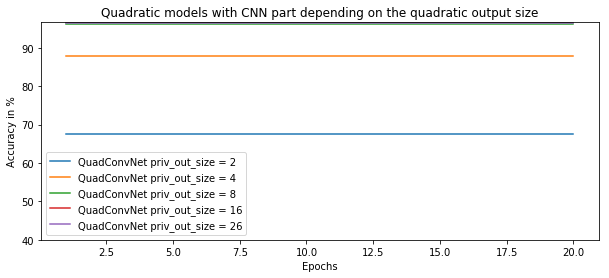

In [7]:
show_results(results, 'Quadratic models with CNN part depending on the quadratic output size', ymin=40)

## Evaluation of models in fixed_precision
We again check that the performance remain similair between the float and the fixed precision model

In [8]:
import syft as sy
hook = sy.TorchHook(torch)

In [9]:
def fixp_test(model, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model.fixp_forward(data, PREC_FRAC) # <-- forward call with the private part in fixed precision
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return [acc]



Get the data we didn't load earlier

In [10]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)

Training set 60000 items
Testing set  10000 items


Launch a test estimation on each model where the quadratic part is set in fixed precision

In [11]:
args = Parser()
for private_output_size in OUT_SIZE_RANGE:
    label = get_label(private_output_size)
    quadconv_model = quadconv_models[label] # retrieve the model
    quadconv_model.eval()
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    acc = fixp_test(quadconv_model, test_loader)
    results[f'Fix prec. {label}'] = acc * len(results[label])
    print('Acc', acc, label)

/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:194: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)



Test set: Average loss: 0.0010, Accuracy: 6754/10000 (67.54%)

Acc [67.54] QuadConvNet priv_out_size = 2

Test set: Average loss: 0.0004, Accuracy: 8789/10000 (87.89%)

Acc [87.89] QuadConvNet priv_out_size = 4

Test set: Average loss: 0.0001, Accuracy: 9620/10000 (96.20%)

Acc [96.2] QuadConvNet priv_out_size = 8

Test set: Average loss: 0.0001, Accuracy: 9660/10000 (96.60%)

Acc [96.6] QuadConvNet priv_out_size = 16

Test set: Average loss: 0.0001, Accuracy: 9656/10000 (96.56%)

Acc [96.56] QuadConvNet priv_out_size = 26


### Comparison between fixed precision and float models

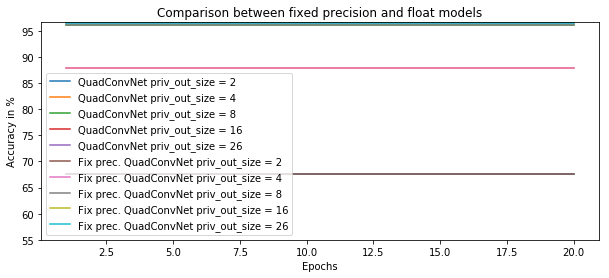

In [12]:
show_results(results, 'Comparison between fixed precision and float models', ymin=55)

#  2. Collateral task

We will copy the parameters of the quadratic part of the QuadConvNets in a simple QuadNet to be closer to what we did in Part 4.

In [13]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def feed(self, quad_conv_net):
        """Copy the weights of the QuadConvNet"""
        self.proj1.bias = nn.Parameter(quad_conv_net.proj1.bias.clone())
        self.proj1.weight = nn.Parameter(quad_conv_net.proj1.weight.clone())
        self.diag1.bias = nn.Parameter(quad_conv_net.diag1.bias.clone())
        self.diag1.weight = nn.Parameter(quad_conv_net.diag1.weight.clone())

## Setting up the adversarial task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `collateral_model` which will try to predict on another task, namely the family recognition.
We will use function from our library which are very close to the one seen in Part 4.

In [14]:
from learn.collateral import collateral_task

In [15]:
class CollateralCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CollateralCNN, self).__init__()
        self.lin1 = nn.Linear(input_size, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
OUT_SIZE_RANGE = [2, 4, 8, 16, 26]
args = Parser()

for private_output_size in OUT_SIZE_RANGE: # TODO change range
    label = get_label(private_output_size)
    quadconv_model = quadconv_models[label] # retrieve the model
    quadconv_model.eval()
    quad_model = QuadNet(private_output_size)
    quad_model.feed(quadconv_model) # Take the weights from the quadconv_model
    quad_model.fix_precision() # Put the weights in fiex precision
    collateral_model = CollateralCNN(input_size=private_output_size, output_size=26)
    results[f'Collateral {label}'] = collateral_task(args, quad_model, collateral_model, PREC_FRAC)
    
    # TODO finish
    path = f'../data/models/part7/Collateral {label}.pt'
    if False:
        if not FORCE_RETRAIN:
            try:
                model.load_state_dict(torch.load(path))
                model.eval()
                # TODO add test phase
            except FileNotFoundError:
                FORCE_RETRAIN = True

        if FORCE_RETRAIN:
            results[label] = main(
                model=quadconv_model, args=Parser(), model_type='quad', task='char'
            )
            quadconv_models[label] = quadconv_model
            torch.save(quadconv_model.state_dict(), path)

Training set 60000 items
Testing set  10000 items


/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:194: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)


Train Epoch: 1 [0/60000 (0%)]	Loss: 3.821211
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.493250
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.416878
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.233757

Test set: Average loss: 0.0013, Accuracy: 4550/10000 (45.50%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.244986
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.207846
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.125212
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.079855

Test set: Average loss: 0.0011, Accuracy: 5443/10000 (54.43%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.107322
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.067610
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.926968
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.918141

Test set: Average loss: 0.0010, Accuracy: 5830/10000 (58.30%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.063862
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.845083
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.904375
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.818335

Test set: Average loss: 0.0

Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.633699
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.555091

Test set: Average loss: 0.0007, Accuracy: 7455/10000 (74.55%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.667321
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.647235
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.612087
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.544608

Test set: Average loss: 0.0006, Accuracy: 7474/10000 (74.74%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.788787
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.585897
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.458476
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.631188

Test set: Average loss: 0.0006, Accuracy: 7714/10000 (77.14%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.535138
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.506887
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.384454
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.613687

Test set: Average loss: 0.0007, Accuracy: 7346/10000 (73.46%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.491599

Let's print the accuracy from the collateral models.

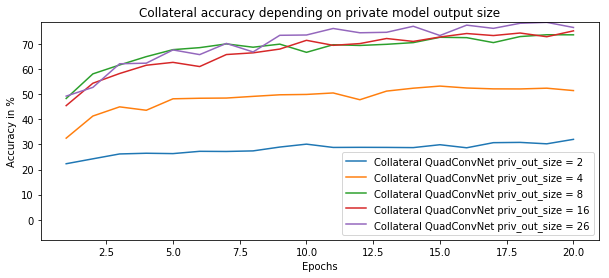

In [22]:
collateral_results = {k: v for k, v in results.items() if 'Collateral ' in k}
show_results(collateral_results, 'Collateral accuracy depending on private model output size', ymin=-8)

#### Discussion

We observe that the collateral learning performs a bit worse in the case we identified to be best in terms of size of the private output and accuracy in the main task, so when `private_output_size = 8`. Indeed we are closer from a 70% accuracy while we claim around 80% in the "uncompressed" scenario where `private_output_size = 26`.

You may notice that in the case `private_output_size = 26` we have slightly different results than in part 6. The reason for this is that the Quad model that we use here is a bit different as it has been trained using a CNN on its output, while in Part 6 we only add the Quadratic part.

### Conclusion

We have vasted interests to use a smaller private output size, because implementation is easier in Functional Encryption and the collateral learning is made harder.
However, this technic is not sufficient to prevent from collateral learning in general. Some other techniques should be investigated.